In [29]:
# Load libraries
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [30]:
from sklearn.linear_model import LogisticRegression
# Import Support Vector Classifier
from sklearn.svm import SVC
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from prep import plot_conf_mat
from sklearn.metrics import confusion_matrix

In [31]:
import sys

import pandas as pd
from sklearn.ensemble import AdaBoostClassifier

from prep import *
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# Load data
df = pd.read_csv('../Datasets/train.csv', encoding='cp1252')


In [32]:
# Do some basic cleaning
processing = 'word_replacement'

if processing in ['basic', 'common_words', 'word_replacement', 'mutual']:
    df_ = prep_data(df)

In [33]:
train_df, val_df = train_test_split(df_, test_size=0.2, random_state=42)
vocab = build_vocab(train_df)

In [34]:
# Reduce features based on mutual information
subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

if processing in ['word_replacement']:
        val = word_replacement(val_df)
        train = word_replacement(train_df)

if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train_df, subreddits, 300)

if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train_df, 3500)
        train, vocab = remove_common_words(train_df, subreddits, 25)
        
# Remove words not in vocab from val
val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

In [35]:
# Remove words not in vocab from val
val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

In [36]:
# Split into X and y
X_train = train['body']
y_train = train['subreddit']
y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
X_val = val['body']
y_val = val['subreddit']
y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

In [37]:
# Vectorize
vec = CountVectorizer(max_features=3000)
# vec = TfidfVectorizer(max_features=3000)
X_train_vec = vec.fit_transform(X_train)
X_val_vec = vec.transform(X_val)
# vec.get_feature_names_out()

# By Default: Ada Boosting with Decision tree base estimator

In [38]:
# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train_vec, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_val_vec)

In [39]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.5347222222222222


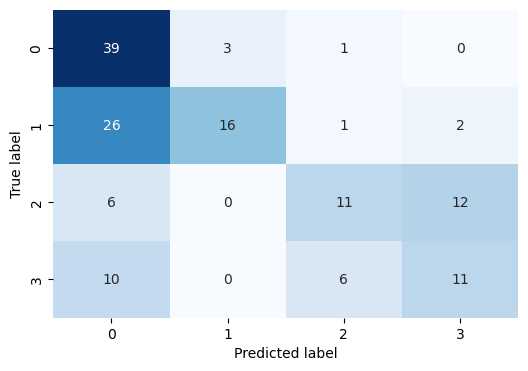

In [40]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_val, y_pred)
plot_conf_mat(conf_mat)

# Use different Base Learners

### Ada Boosting with SVM

In [41]:
svc=SVC(probability=True, kernel='linear')

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=svc,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train_vec, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_val_vec)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))


Accuracy: 0.6944444444444444


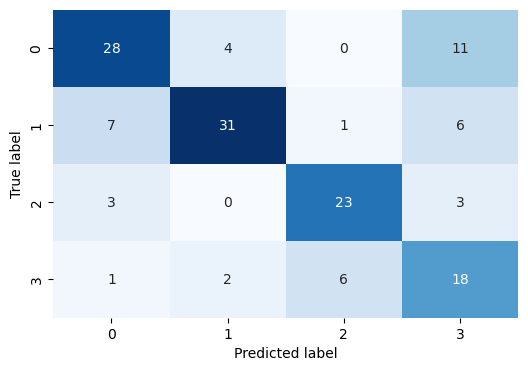

In [42]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_val, y_pred)
plot_conf_mat(conf_mat)

### Ada Boosting with Logistic Regression

In [43]:
LR = LogisticRegression(max_iter=1000)

# Create adaboost classifer object
abc =AdaBoostClassifier(n_estimators=50, base_estimator=LR,learning_rate=1)

# Train Adaboost Classifer
model = abc.fit(X_train_vec, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_val_vec)


# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_val, y_pred))

Accuracy: 0.7013888888888888


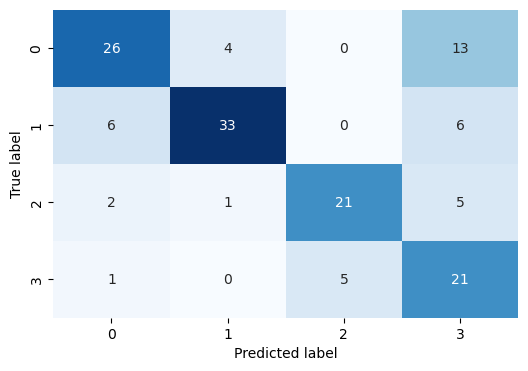

In [44]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_val, y_pred)
plot_conf_mat(conf_mat)

Hence the Logistic Regression base learners have the highest performance, now we try to apply K-Fold Cross Validdation with LR AdaBoosting

# K-Fold AdaBoosting with Logistic Regression base learners

In [45]:
LR = LogisticRegression(max_iter=1000)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df_):
    # Split data
    train = df_.iloc[train_index]
    val = df_.iloc[val_index]
    vocab = build_vocab(train)
    
    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    train, _ = remove_common_words(train, subreddits, 300)
    train = mutual_info_transform(train, 3250)
    train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Vectorize
    vec = CountVectorizer(max_features=3000)
    # vec = TfidfVectorizer(max_features=3000)
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    # vec.get_feature_names_out()

    # Create adaboost classifer object
    abc =AdaBoostClassifier(n_estimators=50, base_estimator=LR,learning_rate=1)

    # Train Adaboost Classifer
    model = abc.fit(X_train_vec, y_train)

    #Predict the response for test dataset
    y_pred = model.predict(X_val_vec)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(y_pred)
    test_acc.append(metrics.accuracy_score(y_val, y_pred))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Accuracy: 0.6111111111111112
Accuracy: 0.7291666666666666
Accuracy: 0.6458333333333334
Accuracy: 0.6388888888888888
Accuracy: 0.6433566433566433
Average accuracy: 0.6536713286713287


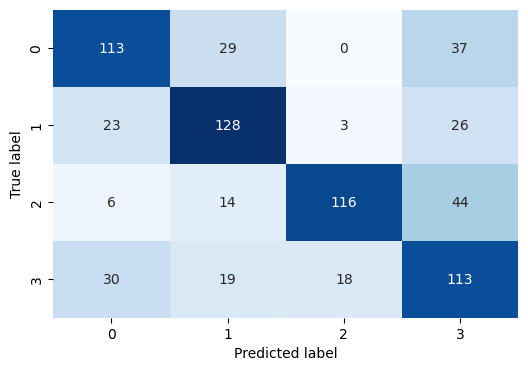

In [46]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)

# Try K-Fold - Logistic Regression - AdaBoosting  with different preprocessing

The result above is with 5-Fold LR AdaBoosting with 'word_replacement' preprocessing. Now we try with different preprocessing approaches.

### 'basic' preprocessing

In [47]:
# Do some basic cleaning
processing = 'basic'

if processing in ['basic', 'common_words', 'word_replacement', 'mutual']:
    df_basic = prep_data(df)

In [48]:
LR = LogisticRegression(max_iter=1000)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df_basic):
    # Split data
    train = df_basic.iloc[train_index]
    val = df_basic.iloc[val_index]
    vocab = build_vocab(train)
    
    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    train, _ = remove_common_words(train, subreddits, 300)
    train = mutual_info_transform(train, 3250)
    train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Vectorize
    vec = CountVectorizer(max_features=3000)
    # vec = TfidfVectorizer(max_features=3000)
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    # vec.get_feature_names_out()

    # Create adaboost classifer object
    abc =AdaBoostClassifier(n_estimators=50, base_estimator=LR,learning_rate=1)

    # Train Adaboost Classifer
    model = abc.fit(X_train_vec, y_train)

    #Predict the response for test dataset
    y_pred = model.predict(X_val_vec)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(y_pred)
    test_acc.append(metrics.accuracy_score(y_val, y_pred))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Accuracy: 0.6458333333333334
Accuracy: 0.6944444444444444
Accuracy: 0.6736111111111112
Accuracy: 0.625
Accuracy: 0.6853146853146853
Average accuracy: 0.6648407148407148


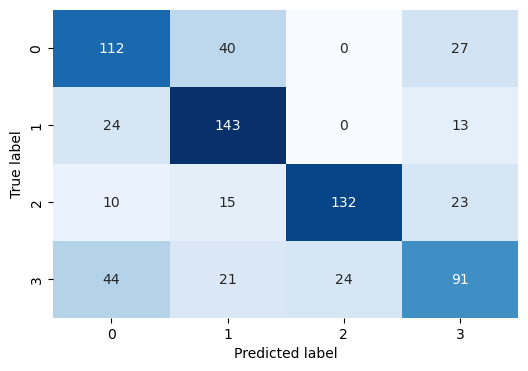

In [49]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)

### 'common_words' preprocessing

In [50]:
# Do some basic cleaning
processing = 'common_words'

if processing in ['basic', 'common_words', 'word_replacement', 'mutual']:
    df_common_words = prep_data(df)

In [51]:
LR = LogisticRegression(max_iter=1000)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df_common_words):
    # Split data
    train = df_common_words.iloc[train_index]
    val = df_common_words.iloc[val_index]
    vocab = build_vocab(train)
    
    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    train, _ = remove_common_words(train, subreddits, 300)
    train = mutual_info_transform(train, 3250)
    train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Vectorize
    vec = CountVectorizer(max_features=3000)
    # vec = TfidfVectorizer(max_features=3000)
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    # vec.get_feature_names_out()

    # Create adaboost classifer object
    abc =AdaBoostClassifier(n_estimators=50, base_estimator=LR,learning_rate=1)

    # Train Adaboost Classifer
    model = abc.fit(X_train_vec, y_train)

    #Predict the response for test dataset
    y_pred = model.predict(X_val_vec)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(y_pred)
    test_acc.append(metrics.accuracy_score(y_val, y_pred))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Accuracy: 0.5833333333333334
Accuracy: 0.6875
Accuracy: 0.6319444444444444
Accuracy: 0.625
Accuracy: 0.6573426573426573
Average accuracy: 0.6370240870240871


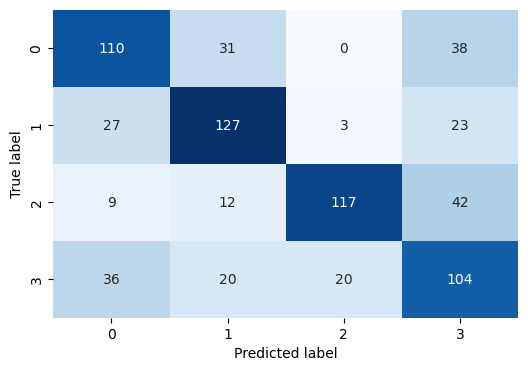

In [52]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)

### 'mutual' preprocessing

In [53]:
# Do some basic cleaning
processing = 'mutual'

if processing in ['basic', 'common_words', 'word_replacement', 'mutual']:
    df_mutual = prep_data(df)

In [54]:
LR = LogisticRegression(max_iter=1000)

# Split data using KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Make list to store accuracies
test_acc = []
y_preds = []
y_vals = []

# Iterate through folds
for train_index, val_index in kf.split(df_mutual):
    # Split data
    train = df_mutual.iloc[train_index]
    val = df_mutual.iloc[val_index]
    vocab = build_vocab(train)
    
    # Reduce features based on mutual information
    subreddits = ['Toronto', 'London', 'Paris', 'Montreal']

    if processing in ['common_words', 'mutual', 'word_replacement']:
        train, vocab = remove_common_words(train, subreddits, 300)

    if processing in ['mutual', 'word_replacement']:
        train = mutual_info_transform(train, 3250)
        train, vocab = remove_common_words(train, subreddits, 25)

    train, _ = remove_common_words(train, subreddits, 300)
    train = mutual_info_transform(train, 3250)
    train, vocab = remove_common_words(train, subreddits, 25)

    # Remove words not in vocab from val
    val['body'] = val['body'].apply(lambda x: ' '.join([word for word in x.split() if word in vocab]))

    # Split into X and y
    X_train = train['body']
    y_train = train['subreddit']
    y_train = y_train.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})
    
    X_val = val['body']
    y_val = val['subreddit']
    y_val = y_val.map({'Toronto': 0, 'London': 1, 'Paris': 2, 'Montreal': 3})

    # Vectorize
    vec = CountVectorizer(max_features=3000)
    # vec = TfidfVectorizer(max_features=3000)
    X_train_vec = vec.fit_transform(X_train)
    X_val_vec = vec.transform(X_val)
    # vec.get_feature_names_out()

    # Create adaboost classifer object
    abc =AdaBoostClassifier(n_estimators=50, base_estimator=LR,learning_rate=1)

    # Train Adaboost Classifer
    model = abc.fit(X_train_vec, y_train)

    #Predict the response for test dataset
    y_pred = model.predict(X_val_vec)

    # Evaluate on validation set
    y_vals.extend(y_val)
    y_preds.extend(y_pred)
    test_acc.append(metrics.accuracy_score(y_val, y_pred))

    # Print accuracy
    print(f'Accuracy: {test_acc[-1]}')

test_acc = np.mean(test_acc)
print(f'Average accuracy: {test_acc}')

Accuracy: 0.6041666666666666
Accuracy: 0.7222222222222222
Accuracy: 0.6319444444444444
Accuracy: 0.625
Accuracy: 0.6433566433566433
Average accuracy: 0.6453379953379953


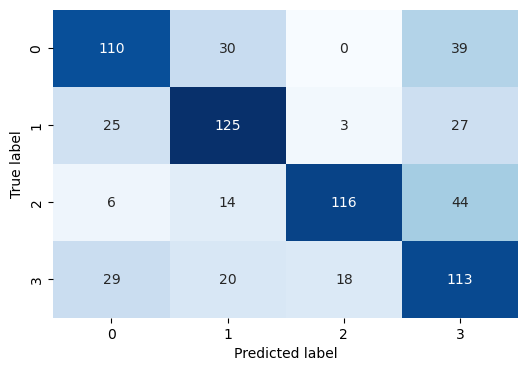

In [55]:
# Plot overall confusion matrix with proper city names
conf_mat = confusion_matrix(y_vals, y_preds)
plot_conf_mat(conf_mat)